# Understanding Convolutional layer

What is the difference between convolutional layer and linear layer?
What kind of intuition is in behind of using convolutional layer in deep neural network?

This hands on shows some effects by convolutional layer to provide some intution about what convolutional layer do.

In [20]:
import os

import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline


def read_rgb_image(imagepath):
    image = cv2.imread(imagepath)  # Height, Width, Channel
    (major, minor, _) = cv2.__version__.split(".")
    if major == '3':
        # version 3 is used, need to convert
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        # Version 2 is used, not necessary to convert
        pass
    return image


def read_gray_image(imagepath):
    image = cv2.imread(imagepath)  # Height, Width, Channel
    (major, minor, _) = cv2.__version__.split(".")
    if major == '3':
        # version 3 is used, need to convert
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        # Version 2 is used, not necessary to convert
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image


def plot_channels(array, filepath='out.jpg'):
    """Plot each channel component separately

    Args:
        array (numpy.ndarray): 3-D array (width, height, channel)

    """
    ch_number = array.shape[2]

    fig, axes = plt.subplots(1, ch_number)
    for i in range(ch_number):
        axes[i].set_title('Channel {}'.format(i))
        axes[i].axis('off')
        axes[i].imshow(array[:, :, i], cmap='gray')

    plt.savefig(filepath)

## convolution layer - basic usage

Input format of convolutional layer is in the order, (batch index, channel, height, width).
Since openCV image format is in the order (height, width, channel), this dimension order 
need to be converted to input to convolution layer.

It can be done by using `transpose` method.


`L.Convolution2D(in_channels, out_channels, ksize)`
 - `in_channels`:  input channel number. 
 - `out_channels`: output channel number.
 - `ksize`:        kernel size.

image.shape (Height, Width, Channel) =  (1426, 1920, 3)
image shape (1, 3, 1426, 1920)


shape (1, 3, 1422, 1916)
shape 2 (1422, 1916, 3)


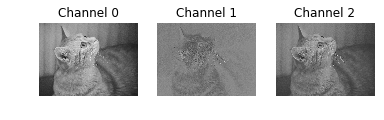

In [23]:
import chainer
import chainer.functions as F
import chainer.links as L

# Read image from file, save image with matplotlib using `imshow` function
basedir = './src/cnn/images'
imagepath = os.path.join(basedir, 'sample.jpeg')

image = read_rgb_image(imagepath)

# height and width shows pixel size of this image 
# Channel=3 indicates the RGB channel 
print('image.shape (Height, Width, Channel) = ', image.shape)

conv1 = L.Convolution2D(None, 3, 5)

# Need to input image of the form (batch index, channel, height, width)
image = image.transpose(2, 0, 1)
image = image[np.newaxis, :, :, :]

# Convert from int to float
image = image.astype(np.float32)
print('image shape', image.shape)
out_image = conv1(image).data
print('shape', out_image.shape)
out_image = out_image[0].transpose(1, 2, 0)
print('shape 2', out_image.shape)
plot_channels(out_image,
              filepath=os.path.join(basedir, 'output_conv1.jpg'))

#plt.imshow(image)
#plt.savefig('./src/cnn/images/out.jpg')

In [33]:
gray_image = read_gray_image(imagepath)
print('gray_image.shape (Height, Width) = ', gray_image.shape)

# Need to input image of the form (batch index, channel, height, width)
gray_image = gray_image[np.newaxis, np.newaxis, :, :]
# Convert from int to float
gray_image = gray_image.astype(np.float32)

conv_vertical = L.Convolution2D(1, 1, 3)
print(conv_vertical.W.data)
conv_vertical.W.data = np.asarray([[[[-1., 0, 1], [-1., 0, 1], [-1., 0, 1]]]])

print('image shape', image.shape)
out_image = conv_vertical(gray_image).data
print('shape', out_image.shape)
out_image = out_image[0].transpose(1, 2, 0)
print('shape 2', out_image.shape)

cv2.imwrite(os.path.join(basedir, 'output_conv_vertical.jpg'), out_image[:, :, 0])
#plt.imshow(out_image[:, :, 0])
#plt.savefig(os.path.join(basedir, 'output_conv_vertical.jpg'))

#plot_channels(out_image,
#              filepath=os.path.join(basedir, 'output_conv_vertical.jpg'))

gray_image.shape (Height, Width) =  (1426, 1920)
[[[[ 0.34701931  0.45331669  0.25057802]
   [-0.51248026 -0.61327946 -0.42902085]
   [ 0.47738615 -0.38392001 -0.02237461]]]]
image shape (1, 3, 1426, 1920)


shape (1, 1, 1424, 1918)
shape 2 (1424, 1918, 1)


True

## Convolution with stride

image.shape (Height, Width, Channel) =  (1, 3, 1426, 1920)
image shape (1, 3, 1426, 1920)


shape (1, 5, 711, 958)
shape 2 (711, 958, 5)


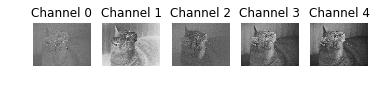

In [5]:
print('image.shape (Height, Width, Channel) = ', image.shape)

conv2 = L.Convolution2D(None, 5, 3, 2)

print('image shape', image.shape)
out_image = conv2(conv1(image)).data
print('shape', out_image.shape)
out_image = out_image[0].transpose(1, 2, 0)
print('shape 2', out_image.shape)
plot_channels(out_image,
              filepath=os.path.join(basedir, 'output_conv2.jpg'))

#plt.imshow(image)
#plt.savefig('./src/cnn/images/out.jpg')

## Max pooling

In [ ]:
## Convolutional neural network